In [1]:
from scipy.optimize import linprog
import seaborn as sns

from scipy.stats import kurtosis, skew
import pandas as pd
from rcv_distribution import *
from rcv_dimensionality import *
from voting_rules import *
from interval_consistency import *
import os

In [5]:
winners = pd.DataFrame(columns=["filename", "diff", "permissive gamma", "#candidates","IRV1", "Condorcet1", "Plurality1", "Approval1" "IRV2", "Condorcet2", "Plurality2", "Approval2"])
directory = "dataverse_files"
count = 0
for filename in os.listdir(directory):
    count += 1

    try:
        csv =  os.path.join(directory, filename)
        ballots, candidates = parse_election_data(csv)

        # Perform the RCV analysis
        csv_data = os.path.join("null_elections", filename)
        data = pd.read_csv(csv_data)
        normalized_distances = {}
        for c in candidates:
            normalized_distances[c] = data.loc[data["candidate"] == c, "position"].values[0]
        
        #running voting rules in the original election 
        org_election = voting_rules(ballots, candidates)
        irv1 = org_election.irv()
        condorcet1 = org_election.condorcet()
        plurality1 = org_election.plurality()
        approval1 = org_election.approval()

        #getting consistent ballots using the interval approach
        consistent_ballots, gamma = get_interval_consistent_ballots(ballots, normalized_distances)
        
        #running voting rules on only consistent ballots
        election = voting_rules(consistent_ballots, candidates)
        irv2 = election.irv()
        condorcet2 = election.condorcet()
        plurality2 = election.plurality()
        approval2 = election.approval()

        diff = []
        if (irv1 != irv2):
            diff.append("IRV")
        if (condorcet1 != condorcet2):
            diff.append("Condorcet")
        if (plurality1 != plurality2):
            diff.append("Plurality")
        if (approval1 != approval2):
            diff.append("Approval")
        winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
                                'Plurality1': plurality1, 'Approval1': approval1,
                                'IRV2': irv2, "Condorcet2": condorcet2, 
                                'Plurality2':plurality2, 'Approval2': approval2}, ignore_index=True)

        if (count % 10 == 0):
            print(count, " ", {'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
                                'Plurality1': plurality1, 'Approval1': approval1,
                                'IRV2': irv2, "Condorcet2": condorcet2, 
                                'Plurality2':plurality2, 'Approval2': approval2})
    except:
        print(filename, " threw an exception")
winners.to_csv('interval_winners.csv', index=False)
    

C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

10   {'filename': 'Alaska_11082022_HouseDistrict15.csv', 'diff': [], 'permissive gamma': 0.9555708390646492, '#candidates': 3, 'IRV1': 'McKay, Thomas W. "Tom"', 'Condorcet1': 'McKay, Thomas W. "Tom"', 'Plurality1': 'Wells, Denny', 'Approval1': 'McKay, Thomas W. "Tom"', 'IRV2': 'McKay, Thomas W. "Tom"', 'Condorcet2': 'McKay, Thomas W. "Tom"', 'Plurality2': 'Wells, Denny', 'Approval2': 'McKay, Thomas W. "Tom"'}


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

20   {'filename': 'Alaska_11082022_HouseDistrict24.csv', 'diff': [], 'permissive gamma': 0.9616, '#candidates': 3, 'IRV1': 'Saddler, Dan', 'Condorcet1': 'Saddler, Dan', 'Plurality1': 'Saddler, Dan', 'Approval1': 'Saddler, Dan', 'IRV2': 'Saddler, Dan', 'Condorcet2': 'Saddler, Dan', 'Plurality2': 'Saddler, Dan', 'Approval2': 'Saddler, Dan'}


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

Alaska_11082022_HouseDistrict3.csv  threw an exception


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

Alaska_11082022_HouseDistrict33.csv  threw an exception


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

Alaska_11082022_HouseDistrict37.csv  threw an exception
Alaska_11082022_HouseDistrict38.csv  threw an exception


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


Alaska_11082022_HouseDistrict40.csv  threw an exception


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


40   {'filename': 'Alaska_11082022_HouseDistrict6.csv', 'diff': [], 'permissive gamma': 0.94118264888142, '#candidates': 3, 'IRV1': 'Vance, Sarah L.', 'Condorcet1': 'Vance, Sarah L.', 'Plurality1': 'Vance, Sarah L.', 'Approval1': 'Vance, Sarah L.', 'IRV2': 'Vance, Sarah L.', 'Condorcet2': 'Vance, Sarah L.', 'Plurality2': 'Vance, Sarah L.', 'Approval2': 'Vance, Sarah L.'}


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


Alaska_11082022_HouseDistrict8.csv  threw an exception


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


Alaska_11082022_SenateDistrictB.csv  threw an exception


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

50   {'filename': 'Alaska_11082022_SenateDistrictG.csv', 'diff': [], 'permissive gamma': 1.0, '#candidates': 2, 'IRV1': 'Gray-Jackson, Elvi', 'Condorcet1': 'Gray-Jackson, Elvi', 'Plurality1': 'Gray-Jackson, Elvi', 'Approval1': 'Gray-Jackson, Elvi', 'IRV2': 'Gray-Jackson, Elvi', 'Condorcet2': 'Gray-Jackson, Elvi', 'Plurality2': 'Gray-Jackson, Elvi', 'Approval2': 'Gray-Jackson, Elvi'}


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

60   {'filename': 'Alaska_11082022_SenateDistrictQ.csv', 'diff': [], 'permissive gamma': 0.9088880338591766, '#candidates': 3, 'IRV1': 'Myers, Robert H. Jr.', 'Condorcet1': 'Myers, Robert H. Jr.', 'Plurality1': 'Myers, Robert H. Jr.', 'Approval1': 'Myers, Robert H. Jr.', 'IRV2': 'Myers, Robert H. Jr.', 'Condorcet2': 'Myers, Robert H. Jr.', 'Plurality2': 'Myers, Robert H. Jr.', 'Approval2': 'Myers, Robert H. Jr.'}


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

Berkeley_11022010_CityAuditor.csv  threw an exception


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


70   {'filename': 'Berkeley_11022010_CityCouncilDistrict1.csv', 'diff': [], 'permissive gamma': 0.9087231797397116, '#candidates': 4, 'IRV1': 'LINDA MAIO', 'Condorcet1': 'LINDA MAIO', 'Plurality1': 'LINDA MAIO', 'Approval1': 'LINDA MAIO', 'IRV2': 'LINDA MAIO', 'Condorcet2': 'LINDA MAIO', 'Plurality2': 'LINDA MAIO', 'Approval2': 'LINDA MAIO'}


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

Berkeley_11042014_CityAuditor.csv  threw an exception


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


80   {'filename': 'Berkeley_11042014_CityCouncilDistrict1.csv', 'diff': [], 'permissive gamma': 0.9389696643331539, '#candidates': 3, 'IRV1': 'LINDA MAIO', 'Condorcet1': 'LINDA MAIO', 'Plurality1': 'LINDA MAIO', 'Approval1': 'LINDA MAIO', 'IRV2': 'LINDA MAIO', 'Condorcet2': 'LINDA MAIO', 'Plurality2': 'LINDA MAIO', 'Approval2': 'LINDA MAIO'}


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

90   {'filename': 'Berkeley_11062018_CityCouncilDistrict4.csv', 'diff': ['Approval'], 'permissive gamma': 0.8940554339897885, '#candidates': 3, 'IRV1': 'KATE HARRISON', 'Condorcet1': 'KATE HARRISON', 'Plurality1': 'KATE HARRISON', 'Approval1': 'KATE HARRISON', 'IRV2': 'KATE HARRISON', 'Condorcet2': 'KATE HARRISON', 'Plurality2': 'KATE HARRISON', 'Approval2': 'BEN GOULD'}


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

100   {'filename': 'Burlington_03072023_CityCouncilCentralDistrict.csv', 'diff': [], 'permissive gamma': 1.0, '#candidates': 2, 'IRV1': 'MELO GRANT', 'Condorcet1': 'MELO GRANT', 'Plurality1': 'MELO GRANT', 'Approval1': 'MELO GRANT', 'IRV2': 'MELO GRANT', 'Condorcet2': 'MELO GRANT', 'Plurality2': 'MELO GRANT', 'Approval2': 'MELO GRANT'}


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


Burlington_03072023_CityCouncilNorthDistrict.csv  threw an exception


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

110   {'filename': 'Hawaii_05232020_PresidentoftheUnitedStateCD1CD2.csv', 'diff': [], 'permissive gamma': 0.8614478499542544, '#candidates': 11, 'IRV1': 'Joseph R. Biden', 'Condorcet1': 'Joseph R. Biden', 'Plurality1': 'Joseph R. Biden', 'Approval1': 'Joseph R. Biden', 'IRV2': 'Joseph R. Biden', 'Condorcet2': 'Joseph R. Biden', 'Plurality2': 'Joseph R. Biden', 'Approval2': 'Joseph R. Biden'}


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

120   {'filename': 'Maine_07142020_DemocraticCandidateforMaineStateHouseDistrict49.csv', 'diff': ['IRV', 'Condorcet', 'Approval'], 'permissive gamma': 0.7762430939226519, '#candidates': 3, 'IRV1': 'Arford, Poppy', 'Condorcet1': 'Arford, Poppy', 'Plurality1': 'Arford, Poppy', 'Approval1': 'Arford, Poppy', 'IRV2': 'Perreault, Corinne Ann', 'Condorcet2': 'Perreault, Corinne Ann', 'Plurality2': 'Arford, Poppy', 'Approval2': 'Perreault, Corinne Ann'}


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

130   {'filename': 'Minneapolis_11022021_CityCouncilWard12.csv', 'diff': [], 'permissive gamma': 0.9784595300261096, '#candidates': 3, 'IRV1': 'Andrew Johnson', 'Condorcet1': 'Andrew Johnson', 'Plurality1': 'Andrew Johnson', 'Approval1': 'Andrew Johnson', 'IRV2': 'Andrew Johnson', 'Condorcet2': 'Andrew Johnson', 'Plurality2': 'Andrew Johnson', 'Approval2': 'Andrew Johnson'}


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

140   {'filename': 'Minneapolis_11022021_Mayor.csv', 'diff': [], 'permissive gamma': 0.8837931753422753, '#candidates': 18, 'IRV1': 'Jacob Frey', 'Condorcet1': 'Jacob Frey', 'Plurality1': 'Jacob Frey', 'Approval1': 'Jacob Frey', 'IRV2': 'Jacob Frey', 'Condorcet2': 'Jacob Frey', 'Plurality2': 'Jacob Frey', 'Approval2': 'Jacob Frey'}


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


Minneapolis_11022021_ParkBoardDistrict1.csv  threw an exception


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

150   {'filename': 'Minneapolis_11052013_PRBoardDistrict6.csv', 'diff': [], 'permissive gamma': 1.0, '#candidates': 2, 'IRV1': 'BRAD BOURN', 'Condorcet1': 'BRAD BOURN', 'Plurality1': 'BRAD BOURN', 'Approval1': 'BRAD BOURN', 'IRV2': 'BRAD BOURN', 'Condorcet2': 'BRAD BOURN', 'Plurality2': 'BRAD BOURN', 'Approval2': 'BRAD BOURN'}


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

Minneapolis_11062009_PRBoardDistrict4.csv  threw an exception


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


160   {'filename': 'Minneapolis_11062009_PRBoardDistrict6.csv', 'diff': [], 'permissive gamma': 0.9549333012859031, '#candidates': 4, 'IRV1': 'Brad Bourn', 'Condorcet1': 'Brad Bourn', 'Plurality1': 'Brad Bourn', 'Approval1': 'Brad Bourn', 'IRV2': 'Brad Bourn', 'Condorcet2': 'Brad Bourn', 'Plurality2': 'Brad Bourn', 'Approval2': 'Brad Bourn'}


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

170   {'filename': 'Minneapolis_11062009_Ward6CityCouncil.csv', 'diff': [], 'permissive gamma': 0.8366182572614108, '#candidates': 6, 'IRV1': 'Robert Lilligren', 'Condorcet1': 'Robert Lilligren', 'Plurality1': 'Robert Lilligren', 'Approval1': 'Robert Lilligren', 'IRV2': 'Robert Lilligren', 'Condorcet2': 'Robert Lilligren', 'Plurality2': 'Robert Lilligren', 'Approval2': 'Robert Lilligren'}


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

180   {'filename': 'Minneapolis_11072017_PRBoardDistrict6.csv', 'diff': ['IRV', 'Condorcet'], 'permissive gamma': 0.9345551157620777, '#candidates': 4, 'IRV1': 'Brad Bourn', 'Condorcet1': 'Brad Bourn', 'Plurality1': 'Brad Bourn', 'Approval1': 'Bob Fine', 'IRV2': 'Bob Fine', 'Condorcet2': 'Bob Fine', 'Plurality2': 'Brad Bourn', 'Approval2': 'Bob Fine'}


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

Minneapolis_11072017_Ward2CityCouncil.csv  threw an exception


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

190   {'filename': 'Minneapolis_11072017_Ward6CityCouncil.csv', 'diff': [], 'permissive gamma': 0.9884961884961885, '#candidates': 4, 'IRV1': 'Abdi Warsame', 'Condorcet1': 'Abdi Warsame', 'Plurality1': 'Abdi Warsame', 'Approval1': 'Abdi Warsame', 'IRV2': 'Abdi Warsame', 'Condorcet2': 'Abdi Warsame', 'Plurality2': 'Abdi Warsame', 'Approval2': 'Abdi Warsame'}


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

200   {'filename': 'NewYorkCity_06222021_DEMBoroughPresidentNewYork.csv', 'diff': [], 'permissive gamma': 0.6821518156259996, '#candidates': 7, 'IRV1': 'Mark D. Levine', 'Condorcet1': 'Mark D. Levine', 'Plurality1': 'Mark D. Levine', 'Approval1': 'Mark D. Levine', 'IRV2': 'Mark D. Levine', 'Condorcet2': 'Mark D. Levine', 'Plurality2': 'Mark D. Levine', 'Approval2': 'Mark D. Levine'}


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

210   {'filename': 'NewYorkCity_06222021_DEMCouncilMember16thCouncilDistrict.csv', 'diff': [], 'permissive gamma': 0.8197450340942781, '#candidates': 4, 'IRV1': 'Althea V. Stevens', 'Condorcet1': 'Althea V. Stevens', 'Plurality1': 'Althea V. Stevens', 'Approval1': 'Althea V. Stevens', 'IRV2': 'Althea V. Stevens', 'Condorcet2': 'Althea V. Stevens', 'Plurality2': 'Althea V. Stevens', 'Approval2': 'Althea V. Stevens'}


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

220   {'filename': 'NewYorkCity_06222021_DEMCouncilMember25thCouncilDistrict.csv', 'diff': [], 'permissive gamma': 0.6789709921618543, '#candidates': 8, 'IRV1': 'Shekar Krishnan', 'Condorcet1': 'Shekar Krishnan', 'Plurality1': 'Yi Andy Chen', 'Approval1': 'Shekar Krishnan', 'IRV2': 'Shekar Krishnan', 'Condorcet2': 'Shekar Krishnan', 'Plurality2': 'Yi Andy Chen', 'Approval2': 'Shekar Krishnan'}


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

230   {'filename': 'NewYorkCity_06222021_DEMCouncilMember34thCouncilDistrict.csv', 'diff': [], 'permissive gamma': 0.8216529429704178, '#candidates': 4, 'IRV1': 'Jennifer Gutierrez', 'Condorcet1': 'Jennifer Gutierrez', 'Plurality1': 'Jennifer Gutierrez', 'Approval1': 'Jennifer Gutierrez', 'IRV2': 'Jennifer Gutierrez', 'Condorcet2': 'Jennifer Gutierrez', 'Plurality2': 'Jennifer Gutierrez', 'Approval2': 'Jennifer Gutierrez'}


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

240   {'filename': 'NewYorkCity_06222021_DEMCouncilMember45thCouncilDistrict.csv', 'diff': [], 'permissive gamma': 0.9294758692267774, '#candidates': 3, 'IRV1': 'Farah N. Louis', 'Condorcet1': 'Farah N. Louis', 'Plurality1': 'Farah N. Louis', 'Approval1': 'Farah N. Louis', 'IRV2': 'Farah N. Louis', 'Condorcet2': 'Farah N. Louis', 'Plurality2': 'Farah N. Louis', 'Approval2': 'Farah N. Louis'}


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

250   {'filename': 'NewYorkCity_06222021_DEMMayorCitywide.csv', 'diff': [], 'permissive gamma': 0.4534466635813615, '#candidates': 13, 'IRV1': 'Eric L. Adams', 'Condorcet1': 'Eric L. Adams', 'Plurality1': 'Eric L. Adams', 'Approval1': 'Eric L. Adams', 'IRV2': 'Eric L. Adams', 'Condorcet2': 'Eric L. Adams', 'Plurality2': 'Eric L. Adams', 'Approval2': 'Eric L. Adams'}


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


NewYorkCity_06222021_REPBoroughPresidentQueens.csv  threw an exception


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

260   {'filename': 'NewYorkCity_06222021_REPMayorCitywide.csv', 'diff': [], 'permissive gamma': 1.0, '#candidates': 2, 'IRV1': 'Curtis A. Sliwa', 'Condorcet1': 'Curtis A. Sliwa', 'Plurality1': 'Curtis A. Sliwa', 'Approval1': 'Curtis A. Sliwa', 'IRV2': 'Curtis A. Sliwa', 'Condorcet2': 'Curtis A. Sliwa', 'Plurality2': 'Curtis A. Sliwa', 'Approval2': 'Curtis A. Sliwa'}


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

Oakland_11022010_SchoolDirectorDistrict2.csv  threw an exception


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


Oakland_11022010_SchoolDirectorDistrict6.csv  threw an exception


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


270   {'filename': 'Oakland_11032020_MemberCityCouncilAtLargeOaklandRCV.csv', 'diff': ['IRV', 'Condorcet', 'Plurality', 'Approval'], 'permissive gamma': 0.8774973881762469, '#candidates': 3, 'IRV1': 'REBECCA KAPLAN', 'Condorcet1': 'REBECCA KAPLAN', 'Plurality1': 'REBECCA KAPLAN', 'Approval1': 'REBECCA KAPLAN', 'IRV2': 'DERRECK B. JOHNSON', 'Condorcet2': 'DERRECK B. JOHNSON', 'Plurality2': 'DERRECK B. JOHNSON', 'Approval2': 'DERRECK B. JOHNSON'}


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

280   {'filename': 'Oakland_11042014_CityCouncilDistrict2.csv', 'diff': ['IRV', 'Condorcet', 'Plurality', 'Approval'], 'permissive gamma': 0.8423728813559322, '#candidates': 5, 'IRV1': 'ABEL GUILLEN', 'Condorcet1': 'ABEL GUILLEN', 'Plurality1': 'ABEL GUILLEN', 'Approval1': 'ABEL GUILLEN', 'IRV2': 'DANA KING', 'Condorcet2': 'DANA KING', 'Plurality2': 'DANA KING', 'Approval2': 'DANA KING'}


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

290   {'filename': 'Oakland_11062012_CityCouncilDistrict3.csv', 'diff': ['Plurality'], 'permissive gamma': 0.7930596507144477, '#candidates': 6, 'IRV1': 'LYNETTE GIBSON-MCELHANEY', 'Condorcet1': 'LYNETTE GIBSON-MCELHANEY', 'Plurality1': 'SEAN SULLIVAN', 'Approval1': 'LYNETTE GIBSON-MCELHANEY', 'IRV2': 'LYNETTE GIBSON-MCELHANEY', 'Condorcet2': 'LYNETTE GIBSON-MCELHANEY', 'Plurality2': 'LYNETTE GIBSON-MCELHANEY', 'Approval2': 'LYNETTE GIBSON-MCELHANEY'}


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

300   {'filename': 'Oakland_11062018_CityCouncilDistrict6.csv', 'diff': [], 'permissive gamma': 0.8419376466644318, '#candidates': 5, 'IRV1': 'LOREN TAYLOR', 'Condorcet1': 'LOREN TAYLOR', 'Plurality1': 'LOREN TAYLOR', 'Approval1': 'LOREN TAYLOR', 'IRV2': 'LOREN TAYLOR', 'Condorcet2': 'LOREN TAYLOR', 'Plurality2': 'LOREN TAYLOR', 'Approval2': 'LOREN TAYLOR'}


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


Oakland_11062018_SchoolDirectorDistrict2.csv  threw an exception


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


Oakland_11082016_CityAttorney.csv  threw an exception


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

310   {'filename': 'Oakland_11082016_CouncilAtLrg.csv', 'diff': [], 'permissive gamma': 0.8187189848512206, '#candidates': 5, 'IRV1': 'REBECCA KAPLAN', 'Condorcet1': 'REBECCA KAPLAN', 'Plurality1': 'REBECCA KAPLAN', 'Approval1': 'REBECCA KAPLAN', 'IRV2': 'REBECCA KAPLAN', 'Condorcet2': 'REBECCA KAPLAN', 'Plurality2': 'REBECCA KAPLAN', 'Approval2': 'REBECCA KAPLAN'}


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

Oakland_11082022_CityAuditor.csv  threw an exception


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

320   {'filename': 'Oakland_11082022_Schoolboarddistrict4.csv', 'diff': ['Condorcet', 'Plurality'], 'permissive gamma': 0.8615576182929591, '#candidates': 3, 'IRV1': 'MIKE HUTCHINSON', 'Condorcet1': -1, 'Plurality1': 'NICK RESNICK', 'Approval1': 'MIKE HUTCHINSON', 'IRV2': 'MIKE HUTCHINSON', 'Condorcet2': 'MIKE HUTCHINSON', 'Plurality2': 'MIKE HUTCHINSON', 'Approval2': 'MIKE HUTCHINSON'}


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

330   {'filename': 'Portland_06142022_Schoolboarddistrict5-1.csv', 'diff': [], 'permissive gamma': 0.8370066632496156, '#candidates': 6, 'IRV1': 'Brydon, Sarah M.', 'Condorcet1': 'Brydon, Sarah M.', 'Plurality1': 'Brydon, Sarah M.', 'Approval1': 'Brydon, Sarah M.', 'IRV2': 'Brydon, Sarah M.', 'Condorcet2': 'Brydon, Sarah M.', 'Plurality2': 'Brydon, Sarah M.', 'Approval2': 'Brydon, Sarah M.'}


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

340   {'filename': 'SanFrancisco_11022004_BoardofSupervisorsDistrict9.csv', 'diff': [], 'permissive gamma': 0.7092232814448333, '#candidates': 6, 'IRV1': 'Tom Ammiano', 'Condorcet1': 'Tom Ammiano', 'Plurality1': 'Tom Ammiano', 'Approval1': 'Tom Ammiano', 'IRV2': 'Tom Ammiano', 'Condorcet2': 'Tom Ammiano', 'Plurality2': 'Tom Ammiano', 'Approval2': 'Tom Ammiano'}


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

350   {'filename': 'SanFrancisco_11032020_BOARDOFSUPERVISORSDISTRICT3.csv', 'diff': [], 'permissive gamma': 0.6955229040622299, '#candidates': 4, 'IRV1': 'AARON PESKIN', 'Condorcet1': 'AARON PESKIN', 'Plurality1': 'AARON PESKIN', 'Approval1': 'AARON PESKIN', 'IRV2': 'AARON PESKIN', 'Condorcet2': 'AARON PESKIN', 'Plurality2': 'AARON PESKIN', 'Approval2': 'AARON PESKIN'}


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

360   {'filename': 'SanFrancisco_11042008_BoardofSupervisorsDistrict9.csv', 'diff': [], 'permissive gamma': 0.8068843711247229, '#candidates': 7, 'IRV1': 'DAVID CAMPOS', 'Condorcet1': 'DAVID CAMPOS', 'Plurality1': 'DAVID CAMPOS', 'Approval1': 'DAVID CAMPOS', 'IRV2': 'DAVID CAMPOS', 'Condorcet2': 'DAVID CAMPOS', 'Plurality2': 'DAVID CAMPOS', 'Approval2': 'DAVID CAMPOS'}


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


SanFrancisco_11052019_CityAttorney.csv  threw an exception


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

SanFrancisco_11052019_PublicDefender.csv  threw an exception
SanFrancisco_11052019_Sheriff.csv  threw an exception
SanFrancisco_11052019_Treasurer.csv  threw an exception


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


370   {'filename': 'SanFrancisco_11062007_Mayor.csv', 'diff': [], 'permissive gamma': 0.9179662937652449, '#candidates': 12, 'IRV1': 'Gavin Newsom', 'Condorcet1': 'Gavin Newsom', 'Plurality1': 'Gavin Newsom', 'Approval1': 'Gavin Newsom', 'IRV2': 'Gavin Newsom', 'Condorcet2': 'Gavin Newsom', 'Plurality2': 'Gavin Newsom', 'Approval2': 'Gavin Newsom'}


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

SanFrancisco_11062018_PublicDefender.csv  threw an exception


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


380   {'filename': 'SanFrancisco_11072006_BoardofSupervisorsDistrict10.csv', 'diff': [], 'permissive gamma': 0.8582600195503421, '#candidates': 7, 'IRV1': 'Sophie Maxwell', 'Condorcet1': 'Sophie Maxwell', 'Plurality1': 'Sophie Maxwell', 'Approval1': 'Sophie Maxwell', 'IRV2': 'Sophie Maxwell', 'Condorcet2': 'Sophie Maxwell', 'Plurality2': 'Sophie Maxwell', 'Approval2': 'Sophie Maxwell'}


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

390   {'filename': 'SanFrancisco_11082016_BoardofSupervisorsDistrict1.csv', 'diff': [], 'permissive gamma': 0.8437411520432881, '#candidates': 10, 'IRV1': 'SANDRA LEE FEWER', 'Condorcet1': 'SANDRA LEE FEWER', 'Plurality1': 'SANDRA LEE FEWER', 'Approval1': 'SANDRA LEE FEWER', 'IRV2': 'SANDRA LEE FEWER', 'Condorcet2': 'SANDRA LEE FEWER', 'Plurality2': 'SANDRA LEE FEWER', 'Approval2': 'SANDRA LEE FEWER'}


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

SanFrancisco_11082022_AssessorRecorder.csv  threw an exception


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


SanFrancisco_11082022_BoardofSupervisorsD2.csv  threw an exception


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


400   {'filename': 'SanFrancisco_11082022_BoardofSupervisorsD6.csv', 'diff': [], 'permissive gamma': 0.738261615790119, '#candidates': 4, 'IRV1': 'MATT DORSEY', 'Condorcet1': 'MATT DORSEY', 'Plurality1': 'MATT DORSEY', 'Approval1': 'MATT DORSEY', 'IRV2': 'MATT DORSEY', 'Condorcet2': 'MATT DORSEY', 'Plurality2': 'MATT DORSEY', 'Approval2': 'MATT DORSEY'}


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

SanLeandro_11022010_CountyCouncilDistrict3.csv  threw an exception


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

SanLeandro_11032020_MemberCityCouncilDist6SanLeandroRCV.csv  threw an exception


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

420   {'filename': 'SanLeandro_11062018_CountyCouncilDistrict5.csv', 'diff': [], 'permissive gamma': 1.0, '#candidates': 2, 'IRV1': 'CORINA N. LOPEZ', 'Condorcet1': 'CORINA N. LOPEZ', 'Plurality1': 'CORINA N. LOPEZ', 'Approval1': 'CORINA N. LOPEZ', 'IRV2': 'CORINA N. LOPEZ', 'Condorcet2': 'CORINA N. LOPEZ', 'Plurality2': 'CORINA N. LOPEZ', 'Approval2': 'CORINA N. LOPEZ'}


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


SanLeandro_11082016_CountyCouncilDistrict4.csv  threw an exception
SanLeandro_11082016_CountyCouncilDistrict6.csv  threw an exception


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

StLouisPark_11022021_CityCouncilWard1.csv  threw an exception


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


StLouisPark_11022021_CityCouncilWard4.csv  threw an exception


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


TakomaPark_11082022_CityCouncilWard2.csv  threw an exception


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


TakomaPark_11082022_CityCouncilWard4.csv  threw an exception


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,


440   {'filename': 'TakomaPark_11082022_Mayor.csv', 'diff': [], 'permissive gamma': 0.7151621384750219, '#candidates': 6, 'IRV1': 'Talisha Searcy', 'Condorcet1': 'Talisha Searcy', 'Plurality1': 'Talisha Searcy', 'Approval1': 'Talisha Searcy', 'IRV2': 'Talisha Searcy', 'Condorcet2': 'Talisha Searcy', 'Plurality2': 'Talisha Searcy', 'Approval2': 'Talisha Searcy'}


C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permissive gamma": gamma, "#candidates": len(candidates), 'IRV1': irv1, 'Condorcet1': condorcet1,
C:\Users\mahsh\AppData\Local\Temp\ipykernel_18576\4165089288.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners = winners.append({'filename': filename, 'diff': diff, "permis

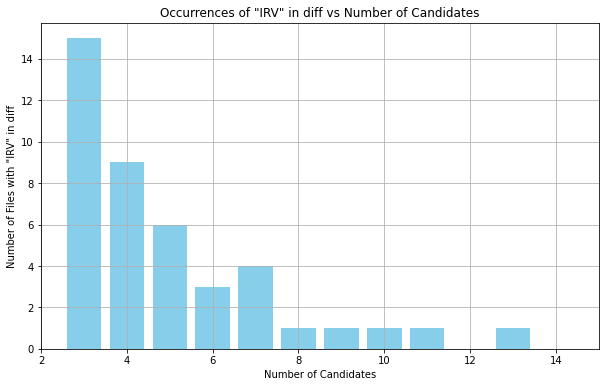

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Read the CSV file into a DataFrame
df = pd.read_csv('interval_winners.csv')

# Step 2: Extract relevant information
df['diff'] = df['diff'].apply(eval)  # Convert string representation to list

# Step 3: Count occurrences of 'IRV'
df['IRV_count'] = df['diff'].apply(lambda x: x.count('IRV'))

# Step 4: Group counts by number of candidates
grouped_data = df.groupby('#candidates')['IRV_count'].sum().reset_index()

# Step 5: Plot
plt.figure(figsize=(10, 6))
plt.bar(grouped_data['#candidates'], grouped_data['IRV_count'], color='skyblue')
plt.xlabel('Number of Candidates')
plt.ylabel('Number of Files with "IRV" in diff')
plt.title('Occurrences of "IRV" in diff vs Number of Candidates')
plt.grid(True)
plt.xlim(2,15)
plt.show()


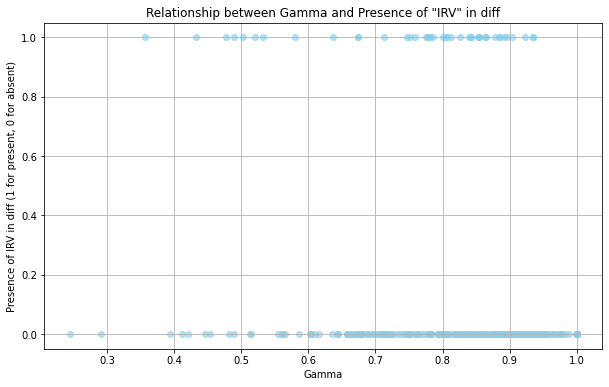

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Read the CSV file into a DataFrame
df = pd.read_csv('interval_winners.csv')

# Step 2: Extract relevant information
df['diff'] = df['diff'].apply(eval)  # Convert string representation to list
df['IRV_present'] = df['diff'].apply(lambda x: 1 if 'IRV' in x else 0)

# Step 3: Plot
plt.figure(figsize=(10, 6))
plt.scatter(df['permissive gamma'], df['IRV_present'], color='skyblue', alpha=0.6)
plt.xlabel('Gamma')
plt.ylabel('Presence of IRV in diff (1 for present, 0 for absent)')
plt.title('Relationship between Gamma and Presence of "IRV" in diff')
plt.grid(True)
plt.show()


In [13]:
import pandas as pd
from tabulate import tabulate

# Step 1: Read the CSV file into a DataFrame
df = pd.read_csv('interval_winners.csv')

# Step 2: Extract relevant information
df['diff'] = df['diff'].apply(eval)  # Convert string representation to list
df['IRV_present'] = df['diff'].apply(lambda x: 1 if 'IRV' in x else 0)

# Step 3: Group by number of candidates and count occurrences of 'IRV'
grouped_data = df.groupby('#candidates')['IRV_present'].sum().reset_index()

# Step 4: Format the table
table = tabulate(grouped_data, headers='keys', tablefmt='pretty')

# Step 5: Print the table
print(table)


+----+-------------+-------------+
|    | #candidates | IRV_present |
+----+-------------+-------------+
| 0  |      2      |      0      |
| 1  |      3      |     15      |
| 2  |      4      |      9      |
| 3  |      5      |      6      |
| 4  |      6      |      3      |
| 5  |      7      |      4      |
| 6  |      8      |      1      |
| 7  |      9      |      1      |
| 8  |     10      |      1      |
| 9  |     11      |      1      |
| 10 |     12      |      0      |
| 11 |     13      |      1      |
| 12 |     14      |      0      |
| 13 |     15      |      0      |
| 14 |     16      |      0      |
| 15 |     18      |      0      |
| 16 |     21      |      0      |
| 17 |     22      |      0      |
| 18 |     29      |      0      |
| 19 |     35      |      0      |
| 20 |     66      |      0      |
+----+-------------+-------------+


In [16]:
import pandas as pd
from tabulate import tabulate

# Step 1: Read the CSV file into a DataFrame
df = pd.read_csv('interval_winners.csv')

# Step 2: Extract relevant information
df['diff'] = df['diff'].apply(eval)  # Convert string representation to list
df['IRV_present'] = df['diff'].apply(lambda x: 1 if 'IRV' in x else 0)

# Step 3: Group by 'level' and count occurrences of 'IRV'
grouped_by_level = df.groupby(['#candidates', 'level'])['IRV_present'].sum().reset_index()

# Step 4: Format the table for 'level'
table_level = tabulate(grouped_by_level, headers='keys', tablefmt='pretty')

# Step 5: Print the table for 'level'
print("Table for 'level':")
print(table_level)

# Step 6: Group by 'type' and count occurrences of 'IRV'
grouped_by_type = df.groupby(['#candidates', 'type'])['IRV_present'].sum().reset_index()

# Step 7: Format the table for 'type'
table_type = tabulate(grouped_by_type, headers='keys', tablefmt='pretty')

# Step 8: Print the table for '


Table for 'level':
+----+-------------+---------+-------------+
|    | #candidates |  level  | IRV_present |
+----+-------------+---------+-------------+
| 0  |      2      |  LOCAL  |      0      |
| 1  |      2      |  STATE  |      0      |
| 2  |      3      | FEDERAL |      1      |
| 3  |      3      |  LOCAL  |     11      |
| 4  |      3      |  STATE  |      3      |
| 5  |      4      | FEDERAL |      0      |
| 6  |      4      |  LOCAL  |      8      |
| 7  |      4      |  STATE  |      1      |
| 8  |      5      |  LOCAL  |      6      |
| 9  |      6      |  LOCAL  |      3      |
| 10 |      7      |  LOCAL  |      4      |
| 11 |      7      |  STATE  |      0      |
| 12 |      8      | FEDERAL |      0      |
| 13 |      8      |  LOCAL  |      1      |
| 14 |      9      | FEDERAL |      0      |
| 15 |      9      |  LOCAL  |      1      |
| 16 |     10      | FEDERAL |      0      |
| 17 |     10      |  LOCAL  |      1      |
| 18 |     11      | FEDERAL |      

In [17]:
import pandas as pd
from tabulate import tabulate

# Step 1: Read the CSV file into a DataFrame
df = pd.read_csv('interval_winners.csv')

# Step 2: Extract relevant information
df['diff'] = df['diff'].apply(eval)  # Convert string representation to list
df['IRV_present'] = df['diff'].apply(lambda x: 1 if 'IRV' in x else 0)

# Step 3: Group by 'level' and count occurrences of 'IRV'
grouped_by_level = df.groupby(['#candidates', 'level'])['IRV_present'].sum().reset_index()

# Step 4: Format the table for 'level'
table_level = tabulate(grouped_by_level, headers='keys', tablefmt='pretty')

# Step 5: Save the table for 'level' to a text file
with open('table_level.txt', 'w') as file:
    file.write(table_level)

# Step 6: Group by 'type' and count occurrences of 'IRV'
grouped_by_type = df.groupby(['#candidates', 'type'])['IRV_present'].sum().reset_index()

# Step 7: Format the table for 'type'
table_type = tabulate(grouped_by_type, headers='keys', tablefmt='pretty')

# Step 8: Save the table for 'type' to a text file
with open('table_type.txt', 'w') as file:
    file.write(table_type)


In [19]:
import pandas as pd
from tabulate import tabulate

# Step 1: Read the CSV file into a DataFrame
df = pd.read_csv('interval_winners.csv')

# Step 2: Extract relevant information
df['diff'] = df['diff'].apply(eval)  # Convert string representation to list
df['IRV_present'] = df['diff'].apply(lambda x: 1 if 'IRV' in x else 0)

# Step 3: Group by number of candidates and count occurrences of 'IRV'
grouped_data = df.groupby('#candidates')['IRV_present'].sum().reset_index()

# Step 4: Format the table
table_candidates = tabulate(grouped_data, headers='keys', tablefmt='pretty')

# Step 5: Save the table to a text file
with open('table_candidates.txt', 'w') as file:
    file.write(table_candidates)


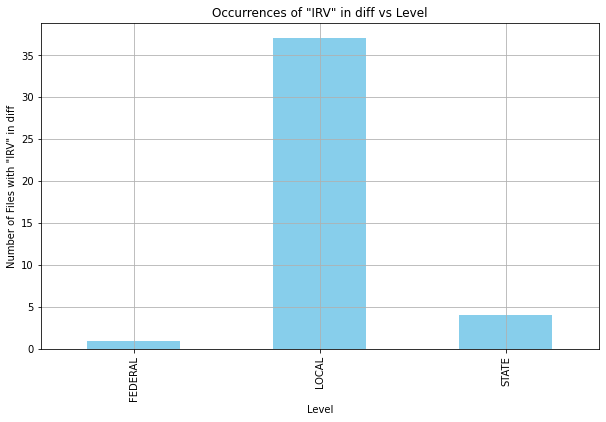

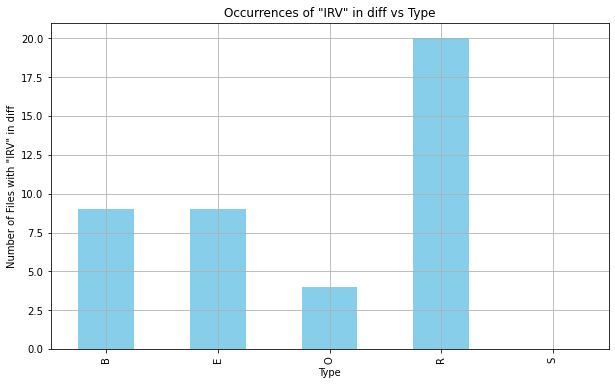

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Read the CSV file into a DataFrame
df = pd.read_csv('interval_winners.csv')

# Step 2: Extract relevant information
df['diff'] = df['diff'].apply(eval)  # Convert string representation to list
df['IRV_present'] = df['diff'].apply(lambda x: 1 if 'IRV' in x else 0)

# Step 3: Plot for 'level'
plt.figure(figsize=(10, 6))
df.groupby('level')['IRV_present'].sum().plot(kind='bar', color='skyblue')
plt.xlabel('Level')
plt.ylabel('Number of Files with "IRV" in diff')
plt.title('Occurrences of "IRV" in diff vs Level')
plt.grid(True)
plt.show()

# Step 4: Plot for 'type'
plt.figure(figsize=(10, 6))
df.groupby('type')['IRV_present'].sum().plot(kind='bar', color='skyblue')
plt.xlabel('Type')
plt.ylabel('Number of Files with "IRV" in diff')
plt.title('Occurrences of "IRV" in diff vs Type')
plt.grid(True)
plt.show()



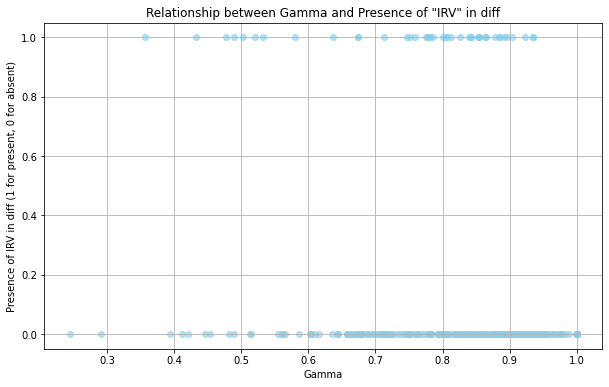

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Read the CSV file into a DataFrame
df = pd.read_csv('interval_winners.csv')

# Step 2: Extract relevant information
df['diff'] = df['diff'].apply(eval)  # Convert string representation to list
df['IRV_present'] = df['diff'].apply(lambda x: 1 if 'IRV' in x else 0)

# Step 3: Plot
plt.figure(figsize=(10, 6))
plt.scatter(df['permissive gamma'], df['IRV_present'], color='skyblue', alpha=0.6)
plt.xlabel('Gamma')
plt.ylabel('Presence of IRV in diff (1 for present, 0 for absent)')
plt.title('Relationship between Gamma and Presence of "IRV" in diff')
plt.grid(True)
plt.show()
